In [281]:
import geopandas as gpd
import contextily as ctx
import pandas as pd
import matplotlib.pyplot as plt
import cartiflette.s3
import numpy as np
import matplotlib as mpl
import math
import unidecode 
import string

from geopandas import GeoDataFrame
from matplotlib import cm
from cartiflette.download import get_vectorfile_ign

In [282]:
df = pd.read_csv("Final Dataset MODS203.csv")
df = df.drop(columns=["Payment_accepted"])
df = df.dropna()
df = df.drop_duplicates()
df

,Name,Type,Speciality,Address,City,Postal_Code
0,Nathalie GARNIER-VIOUGEAT,Physician,Oncologue médical,23 Rue Georges Bizet 75016,Paris,75116
1,Service de chirurgie cancer ORL - Institut Curie,Hospital,Centre de Lutte Contre le Cancer (CLCC),26 Rue d'Ulm,Paris,75005
2,Fabio GIORGIANO,Physician,Chirurgien général,21 Rue Balzac,Paris,75008
3,Hôpital Cochin - AP-HP,Hospital,Hôpital public,123 Boulevard de Port-Royal,Paris,75014
4,Marc Spielmann,Physician,Cancérologue,22 bis rue Georges Bizet,Paris,75116
...,...,...,...,...,...,...
27301,Catherine PERONNET,Physician,Médecin généraliste,29 Avenue Henri Barbusse,Tremblay-en-France,93290
27302,Jacques BOHBOT,Physician,Médecin généraliste,29 Avenue Henri Barbusse,Tremblay-en-France,93290
27304,Centre Municipal de Santé - Mitry Mory,Hospital,Centre de santé,4 Place Nelson Mandela,Mitry-Mory,77290
27305,Dépistage COVID Aéroport Roissy Charles de Gau...,Hospital,Centre de dépistage COVID-19,Terminal 2,Roissy-en-France,95700


### Dataset with the speciality
We first drop the useless columns

In [283]:
df2 = df.drop('Address', axis=1, inplace=False).drop('Name', axis=1, inplace=False).drop('Type', axis=1, inplace=False).drop('City', axis=1, inplace=False)

We then handle the non-normalised values in the *Postal_Code* column

In [284]:
df2['Postal_Code'] = df2['Postal_Code'].replace(['59462 Cedex'], '59')
df2['Postal_Code'] = df2['Postal_Code'].replace(['BOULOGNESURMER'], '62')
df2['Postal_Code'] = df2['Postal_Code'].replace(['FORTMAHONPLAGE'], '80')
df2['Postal_Code'] = df2['Postal_Code'].replace(['L-4048'], '40')
df2['Postal_Code'] = df2['Postal_Code'].replace(['LALLAING'], '59')

We subsequently handle the problematical values in the *Speciality* column

In [285]:
df2['Speciality'] = df2['Speciality'].replace(['Acupunctrice'], 'Acupuncteur')
df2['Speciality'] = df2['Speciality'].replace(['Adjointe chirurgien-dentiste'], 'Chirurgien-dentiste')
df2['Speciality'] = df2['Speciality'].replace(['Adjointe médecin'], 'Médecin généraliste')
df2['Speciality'] = df2['Speciality'].replace(['Adjoint médecin'], 'Médecin généraliste')
df2['Speciality'] = df2['Speciality'].replace(['Adjoint chirurgien-dentiste'], 'Chirurgien-dentiste')
df2['Speciality'] = df2['Speciality'].replace(['Cancérologue médical'], 'Cancérologue')
df2['Speciality'] = df2['Speciality'].replace(['Cancérologue radiothérapeute'], 'Cancérologue')
df2['Speciality'] = df2['Speciality'].replace(['Diététicienne'], 'Diététicien')
df2['Speciality'] = df2['Speciality'].replace(['Gynécologue obstétricien'], 'Gynécologue')
df2['Speciality'] = df2['Speciality'].replace(['Gynécologue médical et obstétrique'], 'Gynécologue')
df2['Speciality'] = df2['Speciality'].replace(['Gynécologue obstétricienne'], 'Gynécologue')
df2['Speciality'] = df2['Speciality'].replace(['Interne en chirurgie dentaire'], 'Chirurgien-dentiste')
df2['Speciality'] = df2['Speciality'].replace(['Interne en médecine'], 'Médecin généraliste')
df2['Speciality'] = df2['Speciality'].replace(['Cabinet médical'], 'Médecin généraliste')
df2['Speciality'] = df2['Speciality'].replace(['Centre dentaire'], 'Chirurgien-dentiste')
df2['Speciality'] = df2['Speciality'].replace(['Centre de santé'], 'Médecin généraliste')
df2['Speciality'] = df2['Speciality'].replace(['Centre médical et dentaire'], 'Médecin généraliste')
df2['Speciality'] = df2['Speciality'].replace(['Cabinet dentaire'], 'Chirurgien-dentiste')
df2['Speciality'] = df2['Speciality'].replace(['Centre de Lutte Contre le Cancer (CLCC)	'], 'Cancérologue')


We subsequently convert all the values to *int* format

In [286]:
for k in df2.index:
    df2['Postal_Code'][k] = int(np.floor(int(df2['Postal_Code'][k])/1000))
    if df2['Postal_Code'][k] < 10:
        df2['Postal_Code'][k] = '0'+str(df2['Postal_Code'][k])
    else :
        df2['Postal_Code'][k] = str(df2['Postal_Code'][k])    
df2

,Speciality,Postal_Code
0,Oncologue médical,75
1,Centre de Lutte Contre le Cancer (CLCC),75
2,Chirurgien général,75
3,Hôpital public,75
4,Cancérologue,75
...,...,...
27301,Médecin généraliste,93
27302,Médecin généraliste,93
27304,Médecin généraliste,77
27305,Centre de dépistage COVID-19,95


We create a new Dataframe containing the total number of specialist

In [289]:
total_by_postcod = df2.groupby(by='Speciality', as_index=False).count()
total_by_postcod.sort_values('Postal_Code', ascending = False)

,Speciality,Postal_Code
46,Médecin généraliste,4781
26,Chirurgien-dentiste,4358
30,Diététicien,2482
58,Ophtalmologue,2121
66,Psychologue,460
...,...,...
27,Chirurgien thoracique et cardio-vasculaire,1
75,Spécialiste en médecine physique et de réadapt...,1
76,Stomatologue,1
77,Échographiste,1


In [290]:
other = 0
for k in total_by_postcod.index:
    if (total_by_postcod['Postal_Code'][k] < 100 and k != 0):
        other += total_by_postcod['Postal_Code'][k] 
        total_by_postcod.drop(index = k, inplace= True)

other+=12 #Acupuncteur
total_by_postcod['Speciality'] = total_by_postcod['Speciality'].replace(['Acupuncteur'], 'Others')
total_by_postcod['Postal_Code'] = total_by_postcod['Postal_Code'].replace([12], other)
total_by_postcod

,Speciality,Postal_Code
0,Others,1015
5,Cabinet paramédical,156
7,Cancérologue,369
26,Chirurgien-dentiste,4358
30,Diététicien,2482
39,Hôpital public,136
46,Médecin généraliste,4781
58,Ophtalmologue,2121
65,Psychiatre,159
66,Psychologue,460


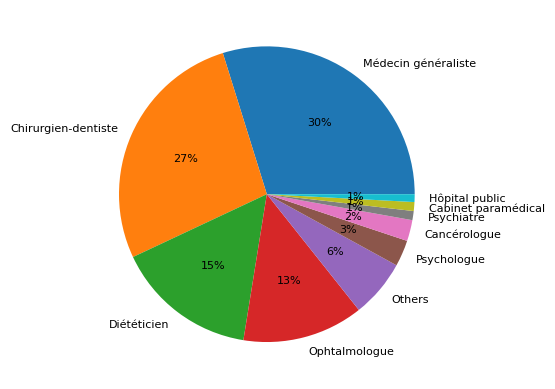

In [291]:
piepl = pd.DataFrame({'Percentage':list(total_by_postcod['Postal_Code']) },
                  index=total_by_postcod['Speciality'])
piepl.sort_values('Percentage', ascending = False).plot(kind='pie', y='Percentage',autopct='%1.0f%%', legend = False)
plt.ylabel(None)
mpl.rcParams['font.size'] = 8

In [292]:
total_by_postcod = df2.groupby(by='Speciality', as_index=False).count()
total_by_postcod.sort_values('Postal_Code', ascending = False)

other = 0
for k in total_by_postcod.index:
    if (total_by_postcod['Postal_Code'][k] < 75):
        other += total_by_postcod['Postal_Code'][k] 
        total_by_postcod.drop(index = k, inplace= True)

other+=12 #Acupuncteur
total_by_postcod['Speciality'] = total_by_postcod['Speciality'].replace(['Médecin généraliste'], 'Others')
total_by_postcod['Postal_Code'] = total_by_postcod['Postal_Code'].replace([4781], other)
total_by_postcod

,Speciality,Postal_Code
5,Cabinet paramédical,156
7,Cancérologue,369
26,Chirurgien-dentiste,4358
30,Diététicien,2482
32,Gynécologue,77
39,Hôpital public,136
46,Others,863
58,Ophtalmologue,2121
65,Psychiatre,159
66,Psychologue,460


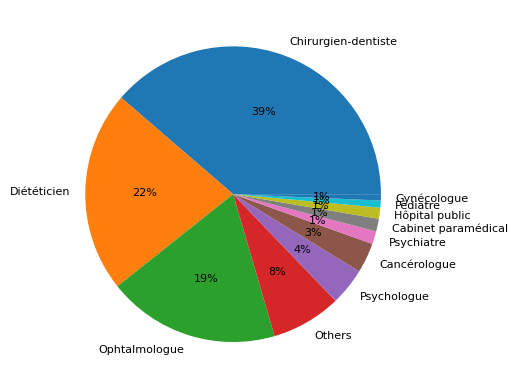

In [293]:
piepl = pd.DataFrame({'Percentage':list(total_by_postcod['Postal_Code']) },
                  index=total_by_postcod['Speciality'])
piepl.sort_values('Percentage', ascending = False).plot(kind='pie', y='Percentage',autopct='%1.0f%%', legend = False)
plt.ylabel(None)
mpl.rcParams['font.size'] = 8

### Dataset with departments

In [294]:
dep_tot = get_vectorfile_ign(
  level = "DEPARTEMENT", field = "metropole",
  source = "COG", provider="opendatarchives")

http://files.opendatarchives.fr/professionnels.ign.fr/adminexpress/ADMIN-EXPRESS-COG_3-1__SHP__FRA_L93_2022-04-15.7z
Data have been previously downloaded and are still available in C:\Users\solal\AppData\Local\Temp/COG-2022


We drop the unused columns as well as Corsica as it was not scapped.

In [295]:
dep = dep_tot.drop('ID', axis=1, inplace=False).drop('INSEE_REG', axis=1, inplace=False).drop('NOM', axis=1, inplace=False)
dep = dep.drop(2).drop(3)
dep.rename(columns = {'INSEE_DEP':'Postal_Code'}, inplace = True)
dep

,NOM_M,Postal_Code,geometry
0,AIN,01,"POLYGON ((838383.200 6570485.800, 838483.800 6..."
1,AISNE,02,"POLYGON ((708719.000 6956305.000, 708718.700 6..."
4,ALLIER,03,"POLYGON ((664478.800 6602292.500, 664503.600 6..."
5,ALPES-DE-HAUTE-PROVENCE,04,"POLYGON ((910451.400 6342553.000, 910484.700 6..."
6,HAUTES-ALPES,05,"POLYGON ((933490.000 6411083.800, 933530.500 6..."
...,...,...,...
91,ESSONNE,91,"POLYGON ((629444.100 6836670.800, 629365.600 6..."
92,HAUTS-DE-SEINE,92,"POLYGON ((642868.900 6869240.500, 642874.900 6..."
93,SEINE-SAINT-DENIS,93,"POLYGON ((660415.900 6872923.300, 660423.700 6..."
94,VAL-DE-MARNE,94,"POLYGON ((650731.000 6857288.700, 650942.200 6..."


### Counting the speciality depending on the department
We do not count the generalist practitioners as specialist.

In [296]:
max_dep = []
for cod in dep['Postal_Code']:
    try :
        if df2[df2['Postal_Code'] == cod].groupby(by='Speciality', as_index=False).count().sort_values(['Postal_Code']).tail(1).values[0][0] == 'Médecin généraliste' and len(df2[df2['Postal_Code'] == cod].groupby(by='Speciality', as_index=False).count().sort_values(['Postal_Code']).tail(2))!=1:
            max_dep.append(df2[df2['Postal_Code'] == cod].groupby(by='Speciality', as_index=False).count().sort_values(['Postal_Code']).tail(2).values[0][0])
        elif len(df2[df2['Postal_Code'] == cod].groupby(by='Speciality', as_index=False).count().sort_values(['Postal_Code']).tail(2)) == 1:
            max_dep.append(0)
        else :
            max_dep.append(df2[df2['Postal_Code'] == cod].groupby(by='Speciality', as_index=False).count().sort_values(['Postal_Code']).tail(1).values[0][0])
    except :
        max_dep.append(0)


dep['Max_Spe'] = max_dep
dep

,NOM_M,Postal_Code,geometry,Max_Spe
0,AIN,01,"POLYGON ((838383.200 6570485.800, 838483.800 6...",Diététicien
1,AISNE,02,"POLYGON ((708719.000 6956305.000, 708718.700 6...",Chirurgien-dentiste
4,ALLIER,03,"POLYGON ((664478.800 6602292.500, 664503.600 6...",Ophtalmologue
5,ALPES-DE-HAUTE-PROVENCE,04,"POLYGON ((910451.400 6342553.000, 910484.700 6...",Diététicien
6,HAUTES-ALPES,05,"POLYGON ((933490.000 6411083.800, 933530.500 6...",Chirurgien-dentiste
...,...,...,...,...
91,ESSONNE,91,"POLYGON ((629444.100 6836670.800, 629365.600 6...",Chirurgien-dentiste
92,HAUTS-DE-SEINE,92,"POLYGON ((642868.900 6869240.500, 642874.900 6...",Chirurgien-dentiste
93,SEINE-SAINT-DENIS,93,"POLYGON ((660415.900 6872923.300, 660423.700 6...",Chirurgien-dentiste
94,VAL-DE-MARNE,94,"POLYGON ((650731.000 6857288.700, 650942.200 6...",Chirurgien-dentiste


In [ ]:
col = dep['Max_Spe'].unique()
col

array(['Diététicien', 'Chirurgien-dentiste', 'Ophtalmologue', 0,
       'Psychologue'], dtype=object)

### Plotting the map
We create a dictionnary aiming at associating a speciality with a colour

In [297]:
coldoc = {
  "Diététicien": "blue",
  "Chirurgien-dentiste": 'green',
  "Ophtalmologue": 'yellow',
  "Psychologue": 'red', 
  0:'grey'}

We then plot the map of the number of doctors depending on the department.

**Warning : the map can take up to 5min to plot (usually less than 3min)**

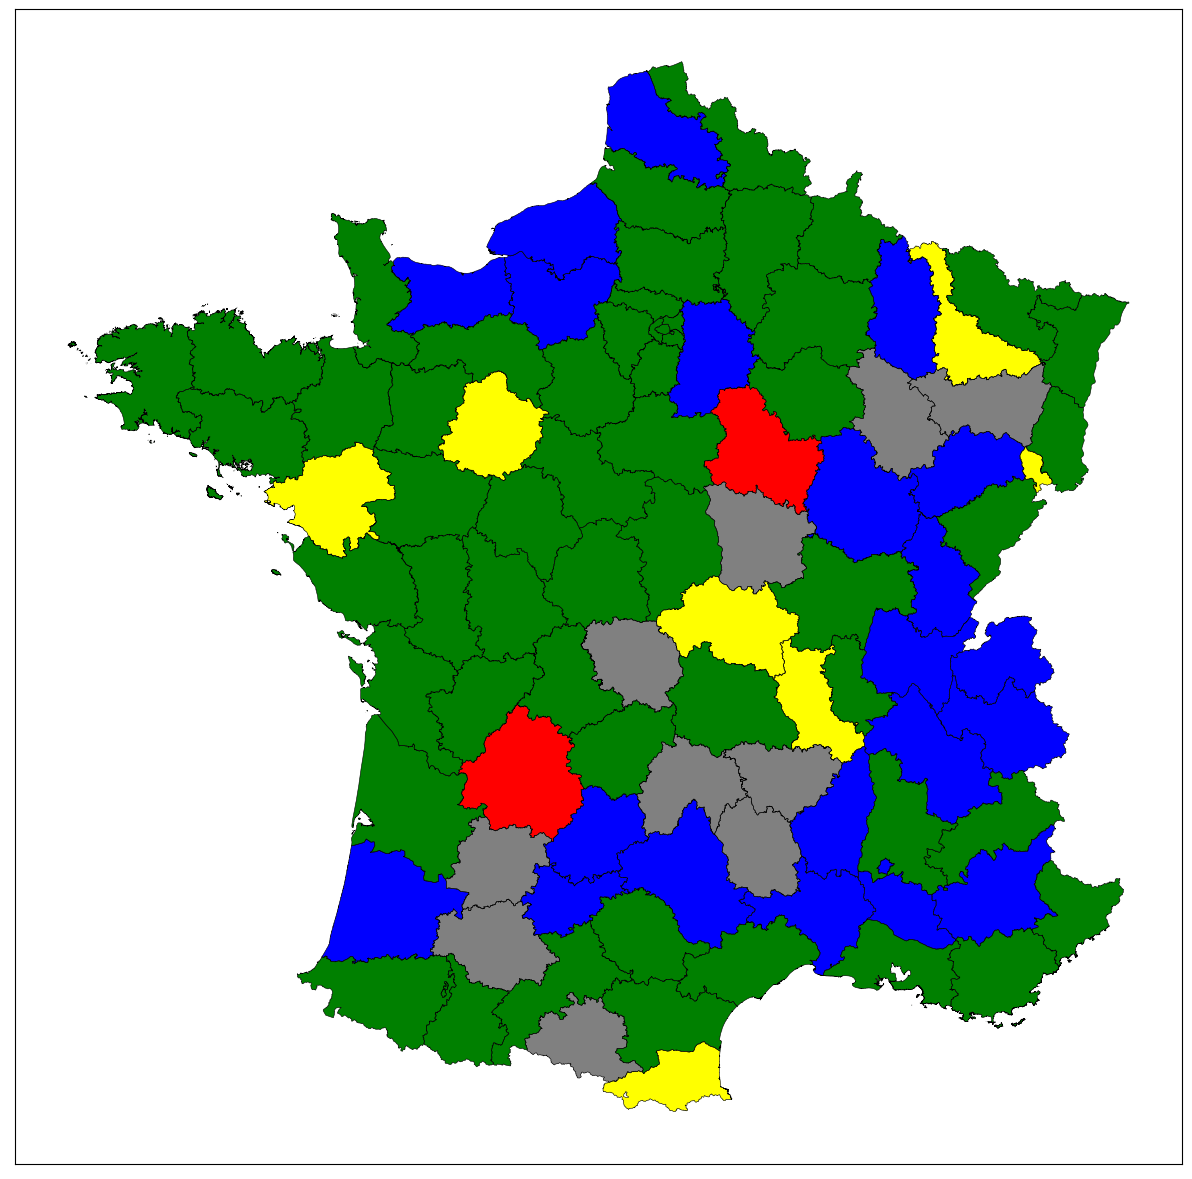

In [299]:
fig = plt.figure(1, figsize=(25,15))
ax = fig.add_subplot()

for k in range(len(list(dep.index))):
    current_dep = dep.iloc[[k]]
    current_dep.boundary.plot(ax=ax, color='Black', linewidth=.4)
    current_dep.plot(ax=ax, color= coldoc[current_dep['Max_Spe'].values[0]], figsize=(12, 12))

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)